# Urban Greenspace and Asthma Prevalence

### Get Started with Big Data Pipelines

Vegetation has the potential to provide many ecosystem services in urban areas, such as cleaner air and water and flood mitigation. However, the results are mixed on relationships between a simple measurement of vegetation cover (such as average NDVI, a measurement of vegetation health) and human health. We do, however, find relationships between landscape metrics that attempt to quantify the connectivity and structure of greenspace and human health. These types of metrics include mean patch size, edge density, and fragmentation.

In this notebook, you will write code to calculate patch, edge, and fragmentation statistics about urban greenspace in Chicago. These statistics should be reflective of the connectivity and spread of urban greenspace, which are important for ecosystem function and access. You will then use a linear model to identify statistically significant correlations between the distribution of greenspace and health data compiled by the US Center for Disease Control.

#### Read More
Check out this study by [Tsai et al. 2019](https://doi.org/10.1007/s11252-018-0813-3) on the relationship between edge density and life expectancy in Baltimore, MD. The authors also discuss the influence of scale (e.g. the resolution of the imagery) on these relationships, which is important for this case study.

Full citation: Tsai, Wei-Lun, Yu-Fai Leung, Melissa R. McHale, Myron F. Floyd, and Brian J. Reich. 2019. “Relationships Between Urban Green Land Cover and Human Health at Different Spatial Resolutions.” *Urban Ecosystems* 22 (2): 315–24. https://doi.org/10.1007/s11252-018-0813-3.

### Working with larger-than-memory (big) data

For this project, we are going to split up the green space (NDVI) data
by census tract, because this matches the human health data from the
CDC. If we were interested in the average NDVI at this spatial scale, we
could easily use a source of multispectral data like Landsat (30m) or
even MODIS (250m) without a noticeable impact on our results. However,
because we need to know more about the structure of green space within
each tract, we need higher resolution data. For that, we will access the
National Agricultural Imagery Program (NAIP) data, which is taken for
the continental US every few years at 1m resolution. That’s enough to
see individual trees and cars! The main purpose of the NAIP data is, as
the name suggests, agriculture. However, it’s also a great source for
urban areas where lots is happening on a very small scale.

The NAIP data for the City of Chicago takes up about 20GB of space. This
amount of data is likely to crash your kernel if you try to load it all
in at once. It also would be inconvenient to store on your harddrive so
that you can load it in a bit at a time for analysis. Even if you are
using a computer that would be able to handle this amount of data,
imagine if you were analysing the entire United States over multiple
years!

To help with this problem, you will use cloud-based tools to calculate
your statistics instead of downloading rasters to your computer or
container. You can crop the data entirely in the cloud, thereby saving
on your memory and internet connection, using `rioxarray`.

### Check your work with testing!

This notebook does not have pre-built tests. You will need to write your
own test code to make sure everything is working the way that you want.
For many operations, this will be as simple as creating a plot to check
that all your data lines up spatially the way you were expecting, or
printing values as you go. However, if you don’t test as you go, you are
likely to end up with intractable problems with the final code.

## STEP 1: Set up your analysis

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>As always, before you get started:</p>
<ol type="1">
<li>Import necessary packages</li>
<li>Create <strong>reproducible file paths</strong> for your project
file structure.</li>
<li>To use cloud-optimized GeoTiffs, we recommend some settings to make
sure your code does not get stopped by a momentary connection lapse –
see the code cell below.</li>
</ol></div></div>

In [1]:
### Import libraries

## for organization 
import os
import pathlib 
import warnings #to see warnings

#for the data analysis

import pandas as pd #for tabular data
import geopandas as gpd #for shapefiles
import numpy as np #for array computations
import xarray as xr 
import rioxarray as rxr #for raster data
import rioxarray.merge as rxrmerge #to mosiac the different raster files 
import shapely #to work with geometries
import time #to work with dates and such

## for plots and visualizing
import geoviews as gv #to see geographic data
import holoviews as hv #for visualizing data
import hvplot.pandas #to plot vector data
import hvplot.xarray
from cartopy import crs as ccrs

## for data exploration
import matplotlib
import scipy.stats as stats
import matplotlib.pyplot as plt

### for images
from scipy.ndimage import convolve
from scipy.ndimage import label

## for working with data in the cloud
import pystac_client
from sodapy import Socrata

## for progess visualization
from tqdm.auto import tqdm

## OLS sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/opt/anaconda3/envs/geo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Create reproducible file paths
data_dir = os.path.join(
    ## home directory
    pathlib.Path.home(),

    ## Earth analytics folder
    'earth-analytics',
    'data',

    ## porject directory
    'urban-green-big-data'
)

os.makedirs(data_dir, exist_ok= True)


In [3]:
### revent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

## STEP 2: Create a site map

We’ll be using the Center for Disease Control (CDC) Places dataset for
human health data to compare with vegetation metrics. CDC Places also provides
some modified census tracts, clipped to the city boundary, to go along
with the health data. We’ll start by downloading the matching geographic
data, and then select the City of Chicago.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Census tract Shapefile that goes along with CDC
Places</li>
<li>Use a <strong>row filter</strong> to select only the census tracts
in Chicago</li>
<li>Use a <strong>conditional statement</strong> to cache your download.
There is no need to cache the full dataset – stick with your pared down
version containing only Chicago.</li>
</ol></div></div>


In [4]:
### Set up the census tract path

## defining my directory
tract_dir = os.path.join(data_dir, 'denver-tract')

## make it
os.makedirs(tract_dir, exist_ok= True)

## make path to directory
tract_path = os.path.join(tract_dir, 'denver-tract.shp')


### Download the census tracts (only once)
if not os.path.exists(tract_path):

    ##put in cenus url
    tract_url = ('https://data.cdc.gov/download/x7zy-2xmx/application%2Fzip')

    ## read the shape file
    tract_gdf = gpd.read_file(tract_url)

    ##subset to Chicago
    chi_tract_gdf = tract_gdf[tract_gdf.PlaceName =='Denver']

    ## save it as a file

    chi_tract_gdf.to_file(tract_path, index = False)

### Load in census tract data
chi_tract_gdf = gpd.read_file(tract_path)
chi_tract_gdf

# Plot Chicago census tracts over satellite imagery

### Site plot -- Census tracts with satellite imagery in the background
(
    chi_tract_gdf

    ## set projection
    .to_crs(ccrs.Mercator())

    #plot with satellite imagery in the background
    .hvplot(
        title="Denver Census Tracts Over Satellite Imagery",
        line_color = 'orange', fill_color = None,
        crs = ccrs.Mercator(), tiles = 'EsriImagery',
        frame_width = 600
    )
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about the City of Chicago from the coarse
satellite image? Is green space evenly distributed? What can you learn
about Chicago from websites, scientific papers, or other resources that
might help explain what you see in the site map?</p></div></div>

Its a little difficult to decifer information from the course sattaleite image, but there are some things that pop out at me right away. The innter-city seems to be more built up, with less green space. On the Northern side of the city, there seems to be a river and a bit more greenspace in the neighborhood sections closer to the city. Just south of the city, it looks like there is an industrial zone with less greenspace.

I found in one article that researchers created very detailed maps of tree and building heights across Chicago using LiDAR and satellite data, which gives a much richer picture of urban vegetation than just canopy area alone. This study showed that knowing where taller trees are located helps us understand how vegetation affects local microclimates, shade, and wind patterns in different neighborhoods (Farid et al., 2023). And in another article, the authors used LiDAR combined with machine learning to estimate both canopy cover and canopy height, and they showed that including tree height in analyses can help planners identify where planting new trees would have the biggest impact by increasing canopy area and improving the quality of the canopy. This is a key role for heat reduction and equity across the city (Francis et al., 2023).


Citations:
Farid, M., El-Sayed, A., & Harrie, L. (2023). Detailed height mapping of trees and buildings (HiTAB) in Chicago and its implications to urban climate studies. Environmental Research Letters, 18(3), Article 034018. https://doi.org/10.1088/1748-9326/ad661a

Francis, M., Jiang, L., & Ghosh, A. (2023). Integrating LiDAR with machine learning for urban canopy cover and height estimation in Chicago. Landscape and Urban Planning, 234, Article 104637. https://www.sciencedirect.com/science/article/pii/S1618866723002868



## STEP 3 - Access Asthma and Urban Greenspaces Data

### Step 3a - Access human health data

The U.S. Center for Disease Control (CDC) provides a number of health
variables through their [Places
Dataset](https://www.cdc.gov/places/index.html) that might be correlated
with urban greenspace. For this assignment, start with adult asthma. Try
to limit the data as much as possible for download. Selecting the state
and county is a one way to do this.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>You can access Places data with an API, but as with many APIs it is
easier to test out your search before building a URL. Navigate to the <a
href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D">Places
Census Tract Data Portal</a> and search for the data you want.</li>
<li>The data portal will make an API call for you, but there is a
simpler, easier to read and modify way to form an API call. Check out to
the <a href="https://dev.socrata.com/docs/endpoints">socrata
documentation</a> to see how. You can also find some limited examples
and a list of available parameters for this API on <a
href="https://dev.socrata.com/foundry/data.cdc.gov/cwsq-ngmh">CDC Places
SODA Consumer API Documentation</a>.</li>
<li>Once you have formed your query, you may notice that you have
exactly 1000 rows. The Places SODA API limits you to 1000 records in a
download. Either narrow your search or check out the
<code>&amp;$limit=</code> parameter to increase the number of rows
downloaded. You can find more information on the <a
href="https://dev.socrata.com/docs/paging">Paging page of the SODA API
documentation</a></li>
<li>You should also clean up this data by renaming the
<code>'data_value'</code> to something descriptive, and possibly
selecting a subset of columns.</li>
</ol></div></div>

In [11]:
### Set up a path for the sleep data
cdc_path = os.path.join(data_dir, 'short_sleep.csv')

### Download sleep data (only once)
if not os.path.exists(cdc_path):

    cdc_url=(
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"
        "?year=2022"
        "&stateabbr=CO"
        "&countyname=Denver"
        "&measureid=SLEEP"   # <-- short sleep duration
        "&$limit=1580"
    )

    # optional but HIGHLY recommended for debugging
    print(cdc_url)

    cdc_df=(

        pd.read_csv(cdc_url)

        ## rename columns
        .rename(columns={
            'data_value':'short_sleep',
            'low_confidence_limit': 'sleep_ci_low',
            'high_confidence_limit': 'sleep_ci_high',
            'locationname': 'tract'
        })

        ## select columns
        [[
          'year','tract',
          'short_sleep','sleep_ci_low','sleep_ci_high',
          'data_value_unit','totalpopulation',
          'totalpop18plus'
        ]]
    )

    ## save to csv
    cdc_df.to_csv(cdc_path, index=False)

### Load in sleep data
cdc_df = pd.read_csv(cdc_path)

### Preview
cdc_df


https://data.cdc.gov/resource/cwsq-ngmh.csv?year=2022&stateabbr=CO&countyname=Denver&measureid=SLEEP&$limit=1580


year       tract  short_sleep  sleep_ci_low  sleep_ci_high  \
0    2022  8031000201         28.3          25.0           31.5   
1    2022  8031000404         25.4          22.3           28.4   
2    2022  8031002704         28.3          25.1           31.4   
3    2022  8031002102         25.6          22.5           28.6   
4    2022  8031000800         40.3          36.5           44.0   
..    ...         ...          ...           ...            ...   
171  2022  8031015800         33.6          30.1           37.1   
172  2022  8031005503         28.1          24.9           31.2   
173  2022  8031004101         33.0          29.4           36.4   
174  2022  8031004308         27.0          23.8           30.0   
175  2022  8031008387         33.1          29.6           36.6   

    data_value_unit  totalpopulation  totalpop18plus  
0                 %             3913            3222  
1                 %             2956            2801  
2                 %             2423            2374  
3                 %             3114            2901  
4                 %             1127             593  
..              ...              ...             ...  
171               %             2893            1899  
172               %             5071            3944  
173               %             4802            3816  
174               %             4132            3731  
175               %             6220            4280  

[176 rows x 8 columns]

In [10]:
### Set up a path for the asthma data
cdc_path = os.path.join(data_dir, 'sleep.csv')

### Download asthma data (only once)
if not os.path.exists(cdc_path):

    cdc_url=(
        ## url for data
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"

        ## parameters to filter
        "?year=2022"
        "&stateabbr=CO"
        "&countyname=Denver"
        "&measureid=LPA"   # <-- frequent mental distress
        "&$limit=1580"
    )

    cdc_df=(

        # open as csv
        pd.read_csv(cdc_url)

        ## rename columns (UNCHANGED)
        .rename(columns={
            'data_value':'asthma',
            'low_confidence_limit': 'asthma_ci_low',
            'high_confidence_limit': 'asthma_ci_high',
            'locationname': 'tract'})

        ## select columns (UNCHANGED)
        [[
          'year','tract',
          'asthma','asthma_ci_low','asthma_ci_high',
          'data_value_unit','totalpopulation',
          'totalpop18plus'  
        ]]

    )

    ## download to csv
    cdc_df.to_csv(cdc_path, index=False)

### Load in asthma data
cdc_df = pd.read_csv(cdc_path)

### Preview asthma data
cdc_df


Empty DataFrame
Columns: [year, tract, asthma, asthma_ci_low, asthma_ci_high, data_value_unit, totalpopulation, totalpop18plus]
Index: []

In [176]:
### Set up a path for the asthma data
cdc_path = os.path.join(data_dir, 'asthma.csv')

### Download asthma data (only once)
if not os.path.exists(cdc_path):

    cdc_url=(
        ##url for data
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"

        ## parameters to filter
        "?year=2023"
        "&stateabbr=IL"
        "&countyname=Cook"
        "&measureid=CASTHMA"
        "&$limit=1580"
    )

    cdc_df=(

        #open as csv
        pd.read_csv(cdc_url)

        ##rename columns
        .rename(columns={
            'data_value':'asthma',
            'low_confidence_limit': 'asthma_ci_low',
            'high_confidence_limit': 'asthma_ci_high',
            'locationname': 'tract'})

        ##select columns i want
        [[
          'year','tract',
          'asthma','asthma_ci_low','asthma_ci_high',
          'data_value_unit','totalpopulation',
          'totalpop18plus'  
        ]]

    )

    ## download to csv
    cdc_df.to_csv(cdc_path, index = False)

### Load in asthma data
cdc_df = pd.read_csv(cdc_path)

### Preview asthma data
cdc_df

year        tract  asthma  asthma_ci_low  asthma_ci_high  \
0     2023  17031071700     9.1            8.1            10.1   
1     2023  17031120300     8.8            7.8             9.8   
2     2023  17031010501     9.9            8.9            11.0   
3     2023  17031031000     8.9            7.9             9.9   
4     2023  17031062400     9.2            8.2            10.3   
...    ...          ...     ...            ...             ...   
1323  2023  17031840400     7.9            7.1             8.8   
1324  2023  17031837300    13.7           12.3            15.0   
1325  2023  17031840000     8.4            7.5             9.3   
1326  2023  17031840700     8.3            7.3             9.2   
1327  2023  17031838700    14.9           13.3            16.6   

     data_value_unit  totalpopulation  totalpop18plus  
0                  %             1660            1325  
1                  %             6920            5212  
2                  %             4206            3762  
3                  %             3868            3439  
4                  %             1673            1389  
...              ...              ...             ...  
1323               %             3369            2662  
1324               %             2489            1835  
1325               %             3001            2428  
1326               %             3900            2885  
1327               %             4132            2874  

[1328 rows x 8 columns]

### Step 3b - Join health data with census tract boundaries

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Join the census tract <code>GeoDataFrame</code> with the asthma
prevalence <code>DataFrame</code> using the <code>.merge()</code>
method.</li>
<li>You will need to change the data type of one of the merge columns to
match, e.g. using <code>.astype('int64')</code></li>
<li>There are a few census tracts in Chicago that do not have data. You
should be able to confirm that they are not listed through the
interactive Places Data Portal. However, if you have large chunks of the
city missing, it may mean that you need to expand the record limit for
your download.</li>
</ol></div></div>

In [13]:
### Change tract identifier datatype for merging
chi_tract_gdf.tract2010 = chi_tract_gdf.tract2010.astype('int64')

# NEW: make CDC tract IDs match tract2010 formatting (11 digits, leading zeros)
cdc_df['tract'] = cdc_df['tract'].astype(str).str.zfill(11).astype('int64')

### Merge census data with geometry
tract_cdc_gdf = (
    chi_tract_gdf
    .merge(
        cdc_df,
        left_on='tract2010',
        right_on='tract',
        how='inner'
    )
)


In [15]:
### Change tract identifier datatype for merging
chi_tract_gdf.tract2010 = chi_tract_gdf.tract2010.astype('int64')

# make CDC tract match the 11-digit tract2010 GEOID format
cdc_df['tract'] = cdc_df['tract'].astype(str).str.zfill(11).astype('int64')

### Merge census data with geometry
tract_cdc_gdf = (
    chi_tract_gdf
    .merge(
        cdc_df,

        ## specifying which columns we're merging on
        left_on='tract2010',
        right_on='tract',

        ## type of join
        how='inner'
    )
)

### Plot short sleep duration as choropleth
(
    gv.tile_sources.EsriImagery
    *
    gv.Polygons(
        tract_cdc_gdf.to_crs(ccrs.Mercator()),

        # CHANGED: map to short sleep
        vdims=['short_sleep', 'tract2010'],

        crs=ccrs.Mercator()
    ).opts(
        color='short_sleep',
        colorbar=True,
        colorbar_opts={'title': 'Short Sleep Duration (%)'},
        tools=['hover']
    )
).opts(
    width=600, height=600,
    xaxis=None, yaxis=None,
    title="Short Sleep Duration (%) Across Denver Census Tracts"
)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (short_sleep,tract2010)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
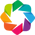

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/1824030936.py:7: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: short_sleep_choropleth.html


In [67]:
# --- Extensions (important for HTML export) ---

import panel as pn


hv.extension("bokeh")
pn.extension()

# --- Your prep ---
chi_tract_gdf["tract2010"] = chi_tract_gdf["tract2010"].astype("int64")

cdc_df["tract"] = (
    cdc_df["tract"]
    .astype(str)
    .str.zfill(11)
    .astype("int64")
)

tract_cdc_gdf = (
    chi_tract_gdf.merge(
        cdc_df,
        left_on="tract2010",
        right_on="tract",
        how="inner",
    )
)

# --- Plot ---
short_sleep_plot = (
    gv.tile_sources.EsriImagery
    * gv.Polygons(
        tract_cdc_gdf.to_crs(ccrs.Mercator()),
        vdims=["short_sleep", "tract2010"],
        crs=ccrs.Mercator(),
    ).opts(
        color="short_sleep",
        colorbar=True,
        colorbar_opts={"title": "Short Sleep Duration (%)"},
        tools=["hover"],
    )
).opts(
    width=600,
    height=600,
    xaxis=None,
    yaxis=None,
    title="Short Sleep Duration (%) Across Denver Census Tracts",
)

# --- Save to HTML (best for GitHub Pages) ---
pn.pane.HoloViews(short_sleep_plot).save(
    "short_sleep_choropleth.html",
    resources="cdn",   # small file, loads JS from CDN (great for GitHub Pages)
    embed=False
)

print("Wrote: short_sleep_choropleth.html")


In [8]:
### Change tract identifier datatype for merging
chi_tract_gdf.tract2010 = chi_tract_gdf.tract2010.astype('int64')

### Merge census data with geometry
tract_cdc_gdf = (
    chi_tract_gdf
    .merge(cdc_df,
           
           ##specfying which columns we're merging on
           left_on= 'tract2010',
           right_on= 'tract',

           ## type of join
           how= 'inner'
           )
)

### Plot asthma data as chloropleth (visualizing the data with color)
(
    #load basemap for satellite imagery
    gv.tile_sources.EsriImagery

    *

    ##map cenus tracts to asthma data
    gv.Polygons(

        ## reproject to align CRS
        tract_cdc_gdf.to_crs(ccrs.Mercator()),

        ## select cols
        vdims =['asthma', 'tract2010'],

        ##ensure CRS aligns
        crs= ccrs.Mercator()
    ).opts(color = 'asthma', colorbar = True, colorbar_opts={'title': 'Asthma Rate %'}, tools =['hover'])
).opts(width = 600, height = 600, xaxis = None, yaxis = None, title="Asthma Rates (%) Across Chicago Census Tracts")


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (asthma,tract2010)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a description and citation for the asthma prevalence data. Do
you notice anything about the spatial distribution of asthma in Chicago?
From your research on the city, what might be some potential causes of
any patterns you see?</p></div></div>

Looking at the asthma rates across Chicago census tracts, it seems like higher asthma is mostly clustered in the more industrial parts of the city, especially on the South and West Sides — which also showed less green space in the satellite imagery. In contrast, neighborhoods along the lakefront and on the North Side appear greener and tend to have lower asthma rates. This lines up with CDC data showing that asthma is more common in lower-income neighborhoods that face higher exposure to air pollution and environmental stressors (CDC, n.d.). A recent report from the Metropolitan Planning Council also notes that many of these same communities experience elevated PM2.5 pollution from nearby industry and traffic, which is strongly linked to respiratory issues like asthma (Metropolitan Planning Council, 2025).

Citations:
Centers for Disease Control and Prevention (CDC). (n.d.). Asthma prevalence — Chicago census tracts [Data set]. https://data.cdc.gov/resource/cwsq-ngmh.csv

Metropolitan Planning Council. (2025). Limited Pollution Exposure Factsheet. https://metroplanning.org/wp-content/uploads/2025/05/Limited-Pollution-Exposure_Factsheet-English_April2025.pdf

### Step 3c - Get data URLs for urban greenspace imagery

NAIP data are freely available through the Microsoft Planetary Computer
SpatioTemporal Access Catalog (STAC).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Get started with STAC by accessing the planetary computer catalog
with the following code:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>e84_catalog <span class="op">=</span> pystac_client.Client.<span class="bu">open</span>(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    <span class="st">&quot;https://planetarycomputer.microsoft.com/api/stac/v1&quot;</span></span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></div></div>

In [16]:
### Connect to the planetary computer catalog
e84_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Use the following sample code to search for data, replacing the
names with applicable values with descriptive names:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>search <span class="op">=</span> e84_catalog.search(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    collections<span class="op">=</span>[<span class="st">&quot;naip&quot;</span>],</span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>    intersects<span class="op">=</span>shapely.to_geojson(tract_geometry),</span>
<span id="cb1-4"><a href="#cb1-4" aria-hidden="true" tabindex="-1"></a>    datetime<span class="op">=</span><span class="ss">f&quot;</span><span class="sc">{</span>year<span class="sc">}</span><span class="ss">&quot;</span></span>
<span id="cb1-5"><a href="#cb1-5" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></li>
<li><p>Access the url using
<code>search.assets['image'].href</code></p></li>
</ol></li>
<li><p>Accumulate the urls in a <code>pd.DataFrame</code> or
<code>dict</code> for later</p></li>
<li><p>Occasionally you may find that the STAC service is momentarily
unavailable. You should include code that will retry the request up to 5
times when you get the
<code>pystac_client.exceptions.APIError</code>.</p></li>
</ol></div></div>

> **Warning**
>
> As always – DO NOT try to write this loop all at once! Stick with one
> step at a time, making sure to test your work. You also probably want
> to add a `break` into your loop to stop the loop after a single
> iteration. This will help prevent long waits during debugging.

In [17]:
### Convert geometry to lat/lon for STAC
tract_latlong_gdf = tract_cdc_gdf.to_crs(4326)

### Define a path to save NDVI stats
ndvi_stats_path = os.path.join(data_dir,'denver-ndvi-stats.csv')

### Check for existing data - do not access duplicate tracts

###initialize empty list for censu tract IDS
downloaded_tracts = []

## write conditional
if os.path.exists(ndvi_stats_path):

    ## if it exists, open the csvs in the path
    ndvi_stats_df = pd.read_csv(ndvi_stats_path)

    ## fill in list with tract values
    downloaded_tracts = ndvi_stats_df.tract.values

#if it doesn't exist, print out a statement
else:
    print('No census tracts downloaded so far :P')



No census tracts downloaded so far :P


In [18]:
## run 1 interation
i = 0
tract_values = tract_latlong_gdf.iloc[i]
tract = tract_values.tract2010
tract

np.int64(8031000102)

In [19]:
## check if stats already downloaded for this tracts
if not (tract in downloaded_tracts):
    print('proceed with the STAC searc')

proceed with the STAC searc


In [23]:
## define naip search
naip_search = e84_catalog.search(

    ##  naip data
    collections = ['naip'],

    ## 2021 imagery specifically
    intersects = shapely.to_geojson(tract_values.geometry),
    datetime = "2021"
)

In [24]:
## naip search

list(naip_search.items())[:2]

## build a datafram
scene_df = pd.DataFrame(dict(

    #tract column
    tract = tract,

    ##date column
    date =[pd.to_datetime(scene.datetime).date()
           
           ## return scenes (STAC ITEMS)
           for scene in naip_search.items()],

    #make rgbir_href
    rgbir_href = [scene.assets['image'].href for scene in naip_search.items()],
        
))

scene_df

tract        date                                         rgbir_href
0  8031000102  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...

In [25]:
## loop through all tracts (one - test)

### Convert geometry to lat/lon for STAC
tract_latlong_gdf = tract_cdc_gdf.to_crs(4326)

### Define a path to save NDVI stats
ndvi_stats_path = os.path.join(data_dir,'denver-ndvi-stats.csv')

### Check for existing data - do not access duplicate tracts
###initialize empty list for censu tract IDS
downloaded_tracts = []

## write conditional
if os.path.exists(ndvi_stats_path):

    ## if it exists, open the csvs in the path
    ndvi_stats_df = pd.read_csv(ndvi_stats_path)

    ## fill in list with tract values
    downloaded_tracts = ndvi_stats_df.tract.values

#if it doesn't exist, print out a statement
else:
    print('No census tracts downloaded so far :P')

### Loop through each census tract

## list to store everything
scene_dfs = []

## loop through each tract value in the gdf
for i, tract_values in tqdm(tract_latlong_gdf.iterrows()):

    ## for i, extract the tract id
    tract = tract_values.tract2010

    ### Check if statistics are already downloaded for this tract

    if not (tract in downloaded_tracts):
        i=0 #retry counter
        retry_limit = 5 ## max number of tries
        while i < retry_limit:
          

            ### Try accessing the STAC
            try:


                ### Search for tiles 
                naip_search= e84_catalog.search(
                    collections = ['naip'],
                    intersects = shapely.to_geojson(tract_values.geometry),
                    datetime="2021"
                )

                ### Build dataframe with tracts and tile urls
                scene_dfs.append(pd.DataFrame(dict(

                    ## column called tract
                    tract = tract,
                    date = [pd.to_datetime(scene.datetime).date()
                            for scene in naip_search.items()],
                    rgbir_href = [scene.assets['image'].href for scene in naip_search.items()],



                )))

                ### exit retry loop oonce STAC request suceeds
                break


            ### Try again in case of an APIError
            except pystac_client.exceptions.APIError:
                print(
                    f'Could not connect with STAC server.'
                    f'Retrying tract {tract}...')
                
                ## wait 2 seconds before retryinging
                time.sleep(2)
                i += 1
                continue



### Concatenate the url dataframes

if scene_dfs:

    ##concatenate
    scene_df = pd.concat(scene_dfs).reset_index(drop = True)

## ptherwise...
else:
    scene_df = None

### Preview the url dataframe
scene_df




No census tracts downloaded so far :P


112it [01:07,  1.65it/s]


tract        date                                         rgbir_href
0    8031000102  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
1    8031000201  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
2    8031000201  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
3    8031000202  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
4    8031000202  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
..          ...         ...                                                ...
180  8031015500  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
181  8031015500  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
182  8031015600  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
183  8031015600  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
184  8031015700  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...

[185 rows x 3 columns]

In [26]:
### write output to csv
scene_df.to_csv(ndvi_stats_path, index=False)
scene_df

tract        date                                         rgbir_href
0    8031000102  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
1    8031000201  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
2    8031000201  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
3    8031000202  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
4    8031000202  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
..          ...         ...                                                ...
180  8031015500  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
181  8031015500  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
182  8031015600  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
183  8031015600  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...
184  8031015700  2021-07-28  https://naipeuwest.blob.core.windows.net/naip/...

[185 rows x 3 columns]

In [27]:
## pull out first tract value
tract = chi_tract_gdf.loc[0].tract2010
tract

## convert to string
tract = str(tract)
tract

'8031000102'

In [28]:
href_value = scene_df.loc[
    scene_df.tract.astype(str) == tract,
    ## column extract
    "rgbir_href"
].iloc[0]

href_value

'https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/16/m_3910516_se_13_060_20210728.tif'

In [29]:
### try processing one scene

### open the raster
tile_da = rxr.open_rasterio(

    ##give it the url
    href_value,

    ##mask out the zero datas
    masked = True

## remove dimensions of length = 1
).squeeze()

tile_da

<xarray.DataArray (band: 4, y: 12230, x: 9600)> Size: 2GB
[469632000 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 98kB 4.407e+06 4.407e+06 ... 4.4e+06 4.4e+06
  * x            (x) float64 77kB 4.944e+05 4.944e+05 ... 5.002e+05 5.002e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [30]:
## look at the dimensions
tile_da.dims
print(scene_df.columns)

Index(['tract', 'date', 'rgbir_href'], dtype='object')


In [31]:
tract_cdc_gdf

place2010   tract2010  ST PlaceName           plctract10  PlcTrPop10  \
0     0820000  8031000102  08    Denver  0820000-08031000102        3109   
1     0820000  8031000201  08    Denver  0820000-08031000201        3874   
2     0820000  8031000202  08    Denver  0820000-08031000202        3916   
3     0820000  8031000301  08    Denver  0820000-08031000301        5003   
4     0820000  8031000302  08    Denver  0820000-08031000302        4036   
..        ...         ...  ..       ...                  ...         ...   
107   0820000  8031015300  08    Denver  0820000-08031015300        3832   
108   0820000  8031015400  08    Denver  0820000-08031015400        3934   
109   0820000  8031015500  08    Denver  0820000-08031015500        3313   
110   0820000  8031015600  08    Denver  0820000-08031015600        6498   
111   0820000  8031015700  08    Denver  0820000-08031015700        5535   

                                              geometry  year       tract  \
0    POLYGON ((-11691351.798 4834636.885, -11691351...  2022  8031000102   
1    POLYGON ((-11688301.532 4835632.272, -11688302...  2022  8031000201   
2    POLYGON ((-11688362.201 4834372.228, -11688360...  2022  8031000202   
3    POLYGON ((-11691355.36 4833538.467, -11691357....  2022  8031000301   
4    POLYGON ((-11692926.635 4832494.047, -11692925...  2022  8031000302   
..                                                 ...   ...         ...   
107  POLYGON ((-11679896.574 4824084.018, -11679896...  2022  8031015300   
108  POLYGON ((-11691351.798 4835608.508, -11691351...  2022  8031015400   
109  MULTIPOLYGON (((-11681197.008 4821951.258, -11...  2022  8031015500   
110  POLYGON ((-11688537.194 4817797.736, -11688985...  2022  8031015600   
111  POLYGON ((-11691342.668 4817773.296, -11691342...  2022  8031015700   

     short_sleep  sleep_ci_low  sleep_ci_high data_value_unit  \
0           27.4          24.3           30.6               %   
1           28.3          25.0           31.5               %   
2           30.0          26.5           33.1               %   
3           24.5          21.5           27.4               %   
4           26.4          23.3           29.4               %   
..           ...           ...            ...             ...   
107         26.9          23.8           29.9               %   
108         28.3          25.1           31.5               %   
109         29.1          25.8           32.3               %   
110         32.2          28.7           35.6               %   
111         29.1          25.8           32.3               %   

     totalpopulation  totalpop18plus  
0               3622            3017  
1               3913            3222  
2               4042            3206  
3               5779            4885  
4               4412            3731  
..               ...             ...  
107             3697            3306  
108             4487            3795  
109             3399            3019  
110             6618            4813  
111             5907            4625  

[112 rows x 15 columns]

In [32]:
tract_cdc_gdf["tract2010"].head()

0    8031000102
1    8031000201
2    8031000202
3    8031000301
4    8031000302
Name: tract2010, dtype: int64

In [33]:
tract in tract_cdc_gdf["tract2010"].astype(str).values

True

### Step 3d- Compute NDVI Statistics

Next, calculate some metrics to get at different aspects of the
distribution of greenspace in each census tract. These types of
statistics are called **fragmentation statistics**, and can be
implemented with the `scipy` package. Some examples of fragmentation
statistics are:

*Percentage vegetation*: The percentage of pixels that exceed a vegetation threshold (.12 is
common with Landsat) Mean patch size

*Mean patch size*: The average size of **patches**, or contiguous area exceeding the
vegetation threshold. Patches can be identified with the `label`
function from `scipy.ndimage` 

*Edge density*: The proportion of edge pixels among vegetated pixels. Edges can be
identified by **convolving** the image with a **kernel** designed to
detect pixels that are different from their surroundings.

> **What is convolution?**
>
> If you are familiar with differential equations, convolution is an
> approximation of the LaPlace transform.
>
> For the purposes of calculating edge density, convolution means that
> we are taking all the possible 3x3 chunks for our image, and
> multiplying it by the kernel:
>
> $$
> \text{Kernel} =
> \begin{bmatrix}
> 1 & 1 & 1 \\
> 1 & -8 & 1 \\
> 1 & 1 & 1
> \end{bmatrix}
> $$
>
> The result is a matrix the same size as the original, minus the
> outermost edge. If the center pixel is the same as the surroundings,
> its value in the final matrix will be
> $-8 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 0$. If it is higher than the
> surroundings, the result will be negative, and if it is lower than the
> surroundings, the result will be positive. As such, the edge pixels of
> our patches will be negative.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Select a single row from the census tract <code>GeoDataFrame</code>
using e.g. <code>.loc[[0]]</code>, then select all the rows from your
URL <code>DataFrame</code> that match the census tract.</li>
<li>For each URL in crop, merge, clip, and compute NDVI for that census
tract</li>
<li>Set a threshold to get a binary mask of vegetation</li>
<li>Using the sample code to compute the fragmentation statistics. Feel
free to add any other statistics you think are relevant, but make sure
to include a fraction vegetation, mean patch size, and edge density. If
you are not sure what any line of code is doing, make a plot or print
something to find out! You can also ask ChatGPT or the class.</li>
</ol></div></div>

### Repeat for all tracts

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Using a loop, for each data URL:</p>
<ol type="1">
<li>Use <code>rioxarray</code> to open up a connection to the STAC
asset, just like you would a file on your computer</li>
<li>Crop and then clip your data to the census tract boundary &gt; HINT:
check out the <code>.clip_box</code> parameter <code>auto_expand</code>
and the <code>clip</code> parameter <code>all_touched</code> to make
sure you don’t end up with an empty array</li>
<li>Compute NDVI for the tract</li>
</ol></li>
<li><p>Merge the NDVI rasters</p></li>
<li><p>Compute:</p>
<ol type="1">
<li>total number of pixels within the tract</li>
<li>fraction of pixels with an NDVI greater than .12 within the tract
(and any other statistics you would like to look at)</li>
</ol></li>
<li><p>Accumulate the statistics in a file for later</p></li>
</ol></li>
<li><p>Using a conditional statement, ensure that you do not run this
computation if you have already saved values. You do not want to run
this step many times, or have to restart from scratch! There are many
approaches to this, but we actually recommend implementing your caching
in the previous cell when you generate your dataframe of URLs, since
that step can take a few minutes as well. However, the important thing
to cache is the computation.</p></li>
</ol></div></div>

In [34]:
## get boundary of tract we are workign with
boundary = (
    tract_cdc_gdf

    ##deal with issues with integers
    .assign(tract2010 = lambda df: df["tract2010"].astype(str))

    ## use tract ID as the index
    .set_index("tract2010")

    ## grab the tract
    .loc[[str(tract)]]

    ## make the CRS match
    .to_crs(tile_da.rio.crs)

    ##grab the geometry
    .geometry
)

boundary

tract2010
8031000102    POLYGON ((497842.209 4403809.736, 497842.293 4...
Name: geometry, dtype: geometry

In [35]:
## crop to bounding box
crop_da = tile_da.rio.clip_box(
    ## get coordinates of the bounding box
    *boundary.envelope.total_bounds,

    ##let it breathe !
    auto_expand = True
)

crop_da

<xarray.DataArray (band: 4, y: 1562, x: 4006)> Size: 100MB
[25029488 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 12kB 4.404e+06 4.404e+06 ... 4.403e+06 4.403e+06
  * x            (x) float64 32kB 4.954e+05 4.954e+05 ... 4.978e+05 4.978e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [37]:
## clip to exact geomtetry of the census tract
clip_da = crop_da.rio.clip(

    boundary,

    ##include all pixels touching the boundary
    all_touched = True

)
clip_da

<xarray.DataArray (band: 4, y: 1562, x: 4006)> Size: 100MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(4, 1562, 4006), dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 12kB 4.404e+06 4.404e+06 ... 4.403e+06 4.403e+06
  * x            (x) float64 32kB 4.954e+05 4.954e+05 ... 4.978e+05 4.978e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [38]:
clip_da.shape

(4, 1562, 4006)

In [39]:
## do the NDVI math
ndvi_da =(
    (clip_da.sel(band = 4) - clip_da.sel(band = 1))
    /(clip_da.sel(band = 4) + clip_da.sel(band = 1))
)
ndvi_da

<xarray.DataArray (y: 1562, x: 4006)> Size: 25MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1562, 4006), dtype=float32)
Coordinates:
  * y            (y) float64 12kB 4.404e+06 4.404e+06 ... 4.403e+06 4.403e+06
  * x            (x) float64 32kB 4.954e+05 4.954e+05 ... 4.978e+05 4.978e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [40]:
### Skip this step if data are already downloaded 
if not scene_df is None:
    ## Get an example
    ## pull out identifier for example tract
    tract = chi_tract_gdf.loc[0].tract2010

    ## subset scene_df to only include that tract
    ex_scene_gdf = scene_df[scene_df.tract == tract]

    ### Loop through the census tracts with URLs
    ### make a list to fill up
    tile_das = []

    ### Open all images for tract
    for _, href_s in ex_scene_gdf.iterrows():

            ### Open vsi connection to data
            tile_da = rxr.open_rasterio(
                  ## point to location 
                  href_s.rgbir_href,

                  ## deal with no data and remove extra dimesions
                  masked = True).squeeze()
            ## crop data to the bounding box of census tract

            ## make bounding box

            boundary= (
                  tract_cdc_gdf
                  ## uses tract id as index
                  .set_index('tract2010')
                  ## select geometry for the tract
                  .loc[[tract]]

                  ## reporject
                  .to_crs(tile_da.rio.crs)

                  ## extract geometry
                  .geometry
            )

            ## crop to boundary box

            crop_da = tile_da.rio.clip_box(
                  
                  ##get coordinates for the bounding box
                  *boundary.envelope.total_bounds,

                  ## expand
                  auto_expand = True
            )

            ### Clip data to bounding box of the census tract
            clip_da = crop_da.rio.clip(
                  boundary, all_touched = True)

            ### Compute NDVI
            ndvi_da = (
                  (clip_da.sel(band=4) - clip_da.sel(band=1))
                  /(clip_da.sel(band=4) + clip_da.sel(band=1))
            )

            ### Accumulate result
            tile_das.append(ndvi_da)
## check
#print(f"Number of tiles in tile_das: {len(tile_das)}")

### Merge data

scene_da = rxrmerge.merge_arrays(tile_das)
scene_da

### Mask vegetation
veg_mask = (scene_da > 0.3)

### Count patch pixels and get patch mean

labeled_patch , num_patches = label(veg_mask)
patch_sizes = np.bincount(labeled_patch.ravel())[1:]
mean_patch_size = patch_sizes.mean()



In [41]:
## Make the kernel to get the edges
kernel = np.array([
      [1, 1, 1],
      [1, -8, 1],
      [1, 1, 1]])

### Calculate edge density
edges = convolve(veg_mask, kernel, mode='constant')
edge_density = np.sum(edges != 0)/veg_mask.size

edge_density

np.float64(0.14472529362166736)

Now loop for everything

In [42]:
## make csv for ndvi data
ndvi_stats_path_veg = os.path.join(data_dir, 'denver-ndvi-stats-veg-test-demo.csv')

In [43]:
### Skip this step if data are already downloaded 
if not scene_df is None:

    ### Loop through all images for tract
    for tract, tract_date_gdf in tqdm(scene_df.groupby('tract')):

        ##open all images for tract
        ## create list to store ndvi arrays 
        tile_das = []
       

        ## iterate over rows in tract-specifc dataframes
        for _, href_s in tract_date_gdf.iterrows():
        
            ### Open vsi connection to data
            tile_da = rxr.open_rasterio(

                ## maske and squeeze
                href_s.rgbir_href, masked = True).squeeze()
            
            ## clip data
            ## get tract boundary
            boundary =(
                tract_cdc_gdf
                .set_index('tract2010')
                .loc[[tract]]
                .to_crs(tile_da.rio.crs)
                .geometry
            )

        ### Crop data to the bounding box of the census tract

        crop_da = tile_da.rio.clip_box(
            *boundary.envelope.total_bounds,
            auto_expand = True
        )


        ### Clip data to the boundary of the census tract
        clip_da = crop_da.rio.clip(boundary, all_touched=True)


        ### Compute NDVI
        ndvi_da = ((clip_da.sel(band = 4) - clip_da.sel(band = 1))
                   /(clip_da.sel(band = 4) + clip_da.sel(band = 1)))
        ### Accumulate result
        tile_das.append(ndvi_da)

        ### Merge data
        scene_da = rxrmerge.merge_arrays(tile_das)

        ### Mask vegetation
        veg_mask = (scene_da > 0.3)

        ## Calculate statitics and save data to file

        ## count all valid pixels in the tract
        total_pixels = scene_da.notnull().sum()

        ## count all vegetated pixels

        veg_pixels = veg_mask.sum()

        ### identify, count, and calculate mean patch size
        labeled_patches, num_patches = label(veg_mask)
        patch_sizes = np.bincount(labeled_patches.ravel())[1:]
        mean_patch_size = patch_sizes.mean()

        ## Calculate edge density

        ### Make kernel to calculate edge density
        kernel = np.array([
            [1, 1, 1], 
            [1, -8, 1], 
            [1, 1, 1]])

        ### detect boundaries using kernal between veg and non-veg
        edges = convolve(veg_mask, kernel, mode='constant')

        ##calculate edge density
        edge_density = np.sum(edges != 0) / veg_mask.size

        ##Add a row to the statitics file for this tracts
        ## create new dataframe for the tract
        pd.DataFrame(dict(

            ## store tract ID
            tract = [tract], 

            ## store total pixels
            total_pixels = [int(total_pixels)],

            ## fraction of veg pixels
            frac_veg = [float(veg_pixels/total_pixels)],

            ## store mean path size
            mean_patch_size = [mean_patch_size],

            ## edge density
            edge_density = [edge_density]

        ## write out as appeneded to csv to  location we identified
        )).to_csv(
            ndvi_stats_path_veg,

            ### appened mode
            mode= 'a',

            ## get rid of row numbers
            index = False,

            ## write column names if the csv doesnt exist yet

            header = (not os.path.exists(ndvi_stats_path_veg))
        )


100%|██████████| 112/112 [25:43<00:00, 13.78s/it]


In [44]:
## check the file
ndvi_stats_df = pd.read_csv(ndvi_stats_path_veg)
ndvi_stats_df

tract  total_pixels  frac_veg  mean_patch_size  edge_density
0    8031000102       5321205  0.315051       208.435907      0.144725
1    8031000201        977901  0.012287        61.615385      0.012154
2    8031000202        690667  0.055249        41.932967      0.059182
3    8031000301       5354592  0.298791       176.550651      0.198788
4    8031000302       4011626  0.297961       158.760393      0.216279
..          ...           ...       ...              ...           ...
107  8031015300       3194630  0.288895       178.755375      0.114123
108  8031015400       7388246  0.368477       216.132026      0.137982
109  8031015500       1629694  0.205275       148.418811      0.097962
110  8031015600       1438512  0.072104        91.953014      0.043531
111  8031015700       5831357  0.274495       169.491847      0.143654

[112 rows x 5 columns]

## STEP 4 - Explore your data with plots

### Chloropleth plots

Before running any statistical models on your data, you should check
that your download worked. You should see differences in both median
income and mean NDVI across the City.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that contains:</p>
<ul>
<li>2 side-by-side chloropleth plots</li>
<li>Asthma prevelence on one plot and mean NDVI on the other</li>
<li>Make sure to include a title and labeled color bars</li>
</ul></div></div>

In [45]:
### Merge census data with geometry

chi_ndvi_cdc_gdf =(

    ## grab census tract gdf
    tract_cdc_gdf

    ## merge with ndvi df
    .merge(
        ndvi_stats_df,

        ## match on tract id
        ## left: tract2010
        ## right: tract

        left_on ='tract2010',
        right_on = 'tract',
        how = 'inner'
    )
)
## check that its merged
chi_ndvi_cdc_gdf 



place2010   tract2010  ST PlaceName           plctract10  PlcTrPop10  \
0     0820000  8031000102  08    Denver  0820000-08031000102        3109   
1     0820000  8031000201  08    Denver  0820000-08031000201        3874   
2     0820000  8031000202  08    Denver  0820000-08031000202        3916   
3     0820000  8031000301  08    Denver  0820000-08031000301        5003   
4     0820000  8031000302  08    Denver  0820000-08031000302        4036   
..        ...         ...  ..       ...                  ...         ...   
107   0820000  8031015300  08    Denver  0820000-08031015300        3832   
108   0820000  8031015400  08    Denver  0820000-08031015400        3934   
109   0820000  8031015500  08    Denver  0820000-08031015500        3313   
110   0820000  8031015600  08    Denver  0820000-08031015600        6498   
111   0820000  8031015700  08    Denver  0820000-08031015700        5535   

                                              geometry  year     tract_x  \
0    POLYGON ((-11691351.798 4834636.885, -11691351...  2022  8031000102   
1    POLYGON ((-11688301.532 4835632.272, -11688302...  2022  8031000201   
2    POLYGON ((-11688362.201 4834372.228, -11688360...  2022  8031000202   
3    POLYGON ((-11691355.36 4833538.467, -11691357....  2022  8031000301   
4    POLYGON ((-11692926.635 4832494.047, -11692925...  2022  8031000302   
..                                                 ...   ...         ...   
107  POLYGON ((-11679896.574 4824084.018, -11679896...  2022  8031015300   
108  POLYGON ((-11691351.798 4835608.508, -11691351...  2022  8031015400   
109  MULTIPOLYGON (((-11681197.008 4821951.258, -11...  2022  8031015500   
110  POLYGON ((-11688537.194 4817797.736, -11688985...  2022  8031015600   
111  POLYGON ((-11691342.668 4817773.296, -11691342...  2022  8031015700   

     short_sleep  sleep_ci_low  sleep_ci_high data_value_unit  \
0           27.4          24.3           30.6               %   
1           28.3          25.0           31.5               %   
2           30.0          26.5           33.1               %   
3           24.5          21.5           27.4               %   
4           26.4          23.3           29.4               %   
..           ...           ...            ...             ...   
107         26.9          23.8           29.9               %   
108         28.3          25.1           31.5               %   
109         29.1          25.8           32.3               %   
110         32.2          28.7           35.6               %   
111         29.1          25.8           32.3               %   

     totalpopulation  totalpop18plus     tract_y  total_pixels  frac_veg  \
0               3622            3017  8031000102       5321205  0.315051   
1               3913            3222  8031000201        977901  0.012287   
2               4042            3206  8031000202        690667  0.055249   
3               5779            4885  8031000301       5354592  0.298791   
4               4412            3731  8031000302       4011626  0.297961   
..               ...             ...         ...           ...       ...   
107             3697            3306  8031015300       3194630  0.288895   
108             4487            3795  8031015400       7388246  0.368477   
109             3399            3019  8031015500       1629694  0.205275   
110             6618            4813  8031015600       1438512  0.072104   
111             5907            4625  8031015700       5831357  0.274495   

     mean_patch_size  edge_density  
0         208.435907      0.144725  
1          61.615385      0.012154  
2          41.932967      0.059182  
3         176.550651      0.198788  
4         158.760393      0.216279  
..               ...           ...  
107       178.755375      0.114123  
108       216.132026      0.137982  
109       148.418811      0.097962  
110        91.953014      0.043531  
111       169.491847      0.143654  

[112 rows x 20 columns]

In [46]:
### Plot chloropleths with vegetation statistics

## make a plot_cholopeth function
def plot_chloropleth(gdf, **opts):

    ## docstring to describe whats going on
    """Generate a Chloropleth with the given color column"""

    ## use geoviews to make a polygon object
    return gv.Polygons(

        ## Use mercator project
        gdf.to_crs(ccrs.Mercator()),

        ##set plot crs to mercator
        crs = ccrs.Mercator()

    ## drop x and y and add a legend
    ).opts(xaxis = None, yaxis = None, colorbar = True, **opts)



In [78]:
### Plot choropleths with vegetation statistics

def plot_chloropleth(gdf, **opts):
    """
    Generate a choropleth with consistent sizing + formatting
    """
    
    
    return gv.tile_sources.EsriImagery*gv.Polygons(
        gdf.to_crs(ccrs.Mercator()),
        crs=ccrs.Mercator()
    ).opts(
        xaxis=None,
        yaxis=None,
        colorbar=True,

        # NEW: consistent sizing
        width=520,
        height=520,

        # NEW: nicer typography
        fontsize={
            'title': 16,
            'labels': 12,
            'ticks': 10
        },

        # NEW: colorbar formatting
        colorbar_opts={
            'title_text_font_size': '12pt'
        },

        tools=['hover'],

        **opts
    )


In [93]:
den_ndvi_cdc_gdf = chi_ndvi_cdc_gdf  # <-- just alias it to a Denver name
chi_ndvi_cdc_gdf["geometry"] = chi_ndvi_cdc_gdf.geometry.buffer(0)
chi_ndvi_cdc_gdf = chi_ndvi_cdc_gdf[chi_ndvi_cdc_gdf.is_valid]




In [94]:
plot_chloropleth(
    chi_ndvi_cdc_gdf,
    color="short_sleep",
    cmap="viridis",
    line_color="black",
    line_width=0.5,
)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,short_sleep,sleep_ci_low,sleep_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)

In [91]:
(
    plot_chloropleth(
        chi_ndvi_cdc_gdf,
        color='short_sleep',          # <-- CHANGED
        cmap='viridis',
        title="Short Sleep Duration by Census Tract (Denver)",
        clabel="Short Sleep Duration (%)"
    )
    +
    plot_chloropleth(
        chi_ndvi_cdc_gdf,
        color='edge_density',
        cmap='Greens',
        title="Vegetation Edge Density by Census Tract (Denver)",
        clabel="Vegetation Edge Density"
    )
)


:Layout
   .Overlay.I  :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Polygons.I :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,short_sleep,sleep_ci_low,sleep_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)
   .Overlay.II :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Polygons.I :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,short_sleep,sleep_ci_low,sleep_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
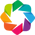

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/2354865705.py:5: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: sleep_vs_vegetation.html


In [86]:
import holoviews as hv
import panel as pn

hv.extension("bokeh")
pn.extension()

# --- Build the combined plot ---
sleep_vs_veg_plot = (
    gv.tile_sources.EsriImagery*plot_chloropleth(
        chi_ndvi_cdc_gdf,
        color="short_sleep",
        cmap="viridis",
        title="Short Sleep Duration by Census Tract (Denver)",
        clabel="Short Sleep Duration (%)",
    )
    +
    gv.tile_sources.EsriImagery*plot_chloropleth(
        chi_ndvi_cdc_gdf,
        color="edge_density",
        cmap="Greens",
        title="Vegetation Edge Density by Census Tract (Denver)",
        clabel="Vegetation Edge Density",
    )
)

# Optional: give it consistent sizing
sleep_vs_veg_plot = sleep_vs_veg_plot.opts(
    width=600,
    height=600,
)

# --- Save to HTML for GitHub Pages ---
pn.pane.HoloViews(sleep_vs_veg_plot).save(
    "sleep_vs_vegetation.html",
    resources="cdn",   # lightweight, perfect for GitHub Pages
    embed=False
)

print("Wrote: sleep_vs_vegetation.html")


In [88]:


def gap_responsibilities(gdf, cols=("short_sleep", "edge_density"), id_col="GEOID"):
    """
    Summarize which polygons appear as 'gaps' (unfilled) in choropleths because
    the mapped column(s) are missing (NaN).

    Returns:
      summary_df: counts + percentages of missingness by column and overlap
      missing_df: per-tract flags for which columns are missing
    """
    # Ensure columns exist
    missing_cols = [c for c in cols if c not in gdf.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in gdf: {missing_cols}")

    n = len(gdf)

    # Build a boolean table of missingness
    miss = pd.DataFrame({c: gdf[c].isna() for c in cols})

    # Use GEOID if present, otherwise fall back to index
    if id_col in gdf.columns:
        miss[id_col] = gdf[id_col].astype(str)
        miss = miss.set_index(id_col)
    else:
        miss.index = gdf.index.astype(str)
        miss.index.name = "index"

    # Counts
    counts = {c: int(miss[c].sum()) for c in cols}
    any_missing = miss.any(axis=1).sum()
    all_missing = miss.all(axis=1).sum()

    # Overlap patterns (e.g., only short_sleep missing, both missing, etc.)
    pattern = miss.astype(int).astype(str).agg("".join, axis=1)
    pattern_counts = pattern.value_counts().sort_index()

    # Human-readable labels for patterns
    # Example for 2 cols:
    # "10" -> first col missing only
    # "01" -> second col missing only
    # "11" -> both missing
    labels = {}
    for p in pattern_counts.index:
        missing_these = [cols[i] for i, ch in enumerate(p) if ch == "1"]
        labels[p] = "none missing" if not missing_these else "missing: " + ", ".join(missing_these)

    summary_rows = []

    # Per-column summaries
    for c in cols:
        summary_rows.append({
            "category": f"missing {c}",
            "count": counts[c],
            "percent": round(100 * counts[c] / n, 2)
        })

    # Combined summaries
    summary_rows.extend([
        {
            "category": "missing any (gap in at least one map)",
            "count": int(any_missing),
            "percent": round(100 * any_missing / n, 2)
        },
        {
            "category": "missing all (gap in both maps)",
            "count": int(all_missing),
            "percent": round(100 * all_missing / n, 2)
        }
    ])

    # Pattern breakdown
    for p, ct in pattern_counts.items():
        summary_rows.append({
            "category": f"pattern {p} ({labels[p]})",
            "count": int(ct),
            "percent": round(100 * ct / n, 2)
        })

    summary_df = pd.DataFrame(summary_rows)

    # Per-tract table so you can inspect which tracts are the gaps
    missing_df = miss.copy()
    missing_df["missing_any"] = miss.any(axis=1)
    missing_df["missing_all"] = miss.all(axis=1)

    return summary_df, missing_df



In [89]:
summary_df, missing_df = gap_responsibilities(
    chi_ndvi_cdc_gdf,
    cols=("short_sleep", "edge_density"),
    id_col="GEOID"  # change if your ID column has a different name
)

summary_df


category  count  percent
0                    missing short_sleep      0      0.0
1                   missing edge_density      0      0.0
2  missing any (gap in at least one map)      0      0.0
3         missing all (gap in both maps)      0      0.0
4              pattern 00 (none missing)    112    100.0

In [48]:
## apply the function to Chicago data
(
    plot_chloropleth(
        ## plot asthma by census tract
        chi_ndvi_cdc_gdf, color ='asthma', cmap = 'viridis',
        title = "Asthma Rates by Census Tract (Chicago)",
        clabel = "Asthma Prevalence (%)"
    )
    +
    ## add a second plot with vegetation edge density
    plot_chloropleth(
        chi_ndvi_cdc_gdf, color = 'edge_density', cmap = 'Greens',
        title = "Vegetation Edge Density by Census Tract (Chicago)",
        clabel = "Vegetation Edge Density"
    )
)


:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,short_sleep,sleep_ci_low,sleep_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)
   .Polygons.II :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,short_sleep,sleep_ci_low,sleep_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Do you see any similarities in your plots? Do you think there is a
relationship between adult asthma and any of your vegetation statistics
in Chicago? Relate your visualization to the research you have done (the
context of your analysis) if applicable.</p></div></div>

Honestly, at first glance adult asthma and vegetation don’t feel directly linked in my maps. If anything, the areas with lower asthma seem to line up with places that have more vegetation edge density. The higher asthma rates show up mostly in more industrial, lower-income neighborhoods, which matches what the articles discussed, especially how air pollution and zoning patterns concentrate in lower income neighborhoods in Chicago (see articles above). It feels less about trees alone and more about long-term exposure to polluted air and unequal access to healthcare, particularly in communities located near factories and major roadways.

## STEP 5: Explore a linear ordinary least-squares regression

### Model description

One way to find if there is a statistically significant relationship
between asthma prevalence and greenspace metrics is to run a linear
ordinary least squares (OLS) regression and measure how well it is able
to predict asthma given your chosen fragmentation statistics.

Before fitting an OLS regression, you should check that your data are
appropriate for the model.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a model description for the linear ordinary least-squares
regression that touches on:</p>
<ol type="1">
<li>Assumptions made about the data</li>
<li>What is the objective of this model? What metrics could you use to
evaluate the fit?</li>
<li>Advantages and potential problems with choosing this model.</li>
</ol></div></div>

Using an ordinary least squares regression means we’re assuming that the relationship between our variables is linear. This whole analysis also assumes that vegetation is a meaningful predictor of adult asthma. If that assumption is wrong and we don’t catch it, the model could introduce bias, which is especially important to think about if results were ever used in publications or decision-making.

The objective of this model is to see whether adult asthma is correlated with vegetation across the city. One way to evaluate the fit is to hold out some data as test data, then compare the model’s predicted asthma rates with the actual observed rates.

An advantage of this model is that it’s simple and easy to interpret. A disadvantage is that it can be misleading if the relationship isn’t actually linear, or if important factors like air pollution, income, or access to healthcare aren’t included in the model.

### Step 5a - Data preparation

When fitting statistical models, you should make sure that your data
meet the model assumptions through a process of selection and/or
transformation.

You can select data by:

-   Eliminating observations (rows) or variables (columns) that are
    missing data
-   Selecting a model that matches the way in which variables are
    related to each other (for example, linear models are not good at
    modeling circles)
-   Selecting variables that explain the largest amount of variability
    in the dependent variable.

You can transform data by:

-   Transforming a variable so that it follows a normal distribution.
    The `log` transform is the most common to eliminate excessive skew
    (e.g. make the data symmetrical), but you should select a transform
    most suited to your data.
-   Normalizing or standardizing variables to, for example, eliminate
    negative numbers or effects caused by variables being in a different
    range.
-   Performing a principle component analysis (PCA) to eliminate
    multicollinearity among the predictor variables

> **Tip**
>
> Keep in mind that data transforms like a log transform or a PCA must
> be reversed after modeling for the results to be meaningful.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the <code>hvplot.scatter_matrix()</code> function to create an
exploratory plot of your data.</li>
<li>Make any necessary adjustments to your data to make sure that they
meet the assumptions of a linear OLS regression.</li>
<li>Check if there are <code>NaN</code> values, and if so drop those
rows and/or columns. You can use the <code>.dropna()</code> method to
drop rows with <code>NaN</code> values.</li>
<li>Explain any data transformations or selections you made and why</li>
</ol></div></div>

In [52]:
## missing variables 
chi_ndvi_cdc_gdf.isna().any()

place2010          False
tract2010          False
ST                 False
PlaceName          False
plctract10         False
PlcTrPop10         False
geometry           False
year               False
tract_x            False
short_sleep        False
sleep_ci_low       False
sleep_ci_high      False
data_value_unit    False
totalpopulation    False
totalpop18plus     False
tract_y            False
total_pixels       False
frac_veg           False
mean_patch_size    False
edge_density       False
dtype: bool

In [53]:
## missing variables per row
chi_ndvi_cdc_gdf.isna().any(axis = 1)

0      False
1      False
2      False
3      False
4      False
       ...  
107    False
108    False
109    False
110    False
111    False
Length: 112, dtype: bool

In [54]:
## any missing values
chi_ndvi_cdc_gdf.isna().any().any()

np.False_

In [209]:
chi_ndvi_cdc_gdf.isna().sum()

place2010          0
tract2010          0
ST                 0
PlaceName          0
plctract10         0
PlcTrPop10         0
geometry           0
year               0
tract_x            0
asthma             0
asthma_ci_low      0
asthma_ci_high     0
data_value_unit    0
totalpopulation    0
totalpop18plus     0
tract_y            0
total_pixels       0
frac_veg           0
mean_patch_size    6
edge_density       0
dtype: int64

In [70]:
### Visualize distribution of data

varibles = ['frac_veg', 'short_sleep', 'mean_patch_size', 'edge_density']

## make scatter plot
hvplot.scatter_matrix(
    chi_ndvi_cdc_gdf
    [varibles]
)

:GridMatrix   [X,Y]
   :Histogram   [short_sleep]   (Count)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
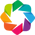

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/1765828975.py:2: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: scatter_matrix_sleep_vegetation.html


In [71]:


hv.extension("bokeh")
pn.extension()

# --- Variables to visualize ---
variables = ["frac_veg", "short_sleep", "mean_patch_size", "edge_density"]

# --- Build scatter matrix ---
scatter_matrix = hvplot.scatter_matrix(
    chi_ndvi_cdc_gdf[variables]
)

# Optional: make it a bit bigger for readability
scatter_matrix = scatter_matrix.opts(
    width=250,
    height=250,
)

# --- Save to HTML for GitHub Pages ---
pn.pane.HoloViews(scatter_matrix).save(
    "scatter_matrix_sleep_vegetation.html",
    resources="cdn",
    embed=False
)

print("Wrote: scatter_matrix_sleep_vegetation.html")


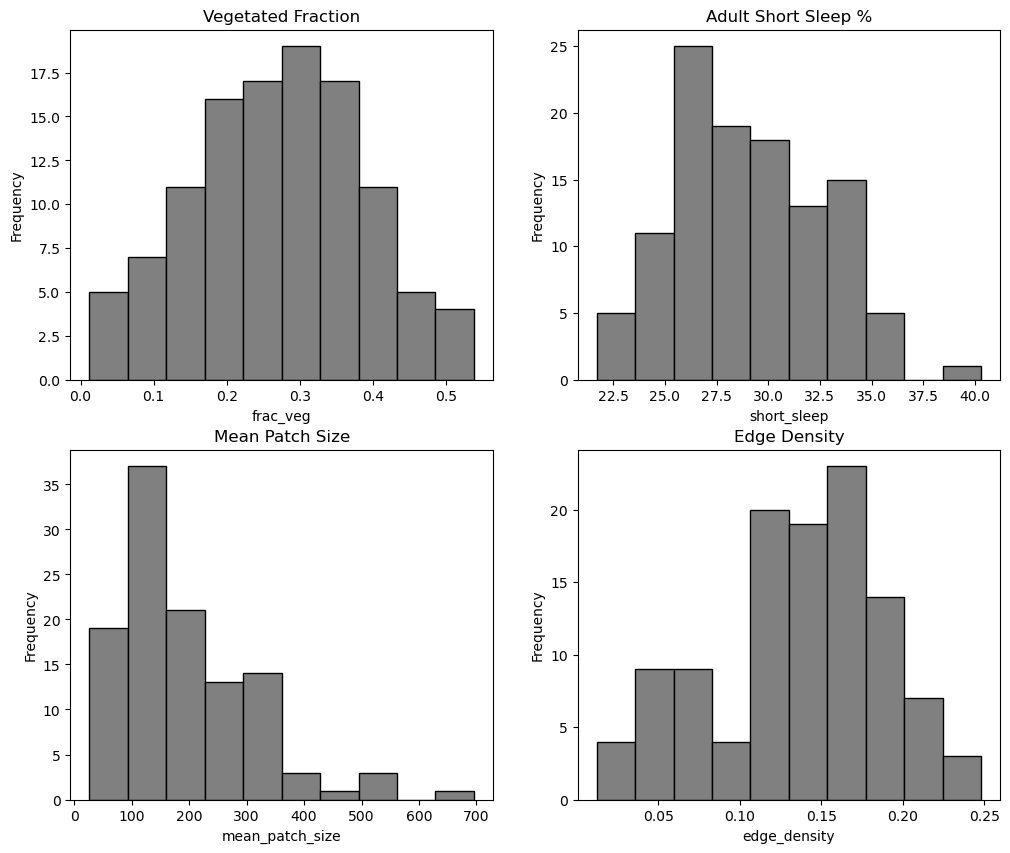

In [69]:
## histograms

## make facet
fig, axes = plt.subplots(2, 2, figsize =(12, 10))

## list variables to plot
varibles = ['frac_veg', 'short_sleep', 'mean_patch_size', 'edge_density']
titles = ['Vegetated Fraction', 'Adult Short Sleep %', 'Mean Patch Size', 'Edge Density']

## loop through variables and axes to plot histograms
for i, (var, title) in enumerate(zip(varibles, titles)):
    ax = axes[i//2, i%2]
    ax.hist(chi_ndvi_cdc_gdf[var], bins = 10, color = 'gray', edgecolor = 'black')
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

## adjust layers to rpvent overlap
plt.tight_layout
plt.show()


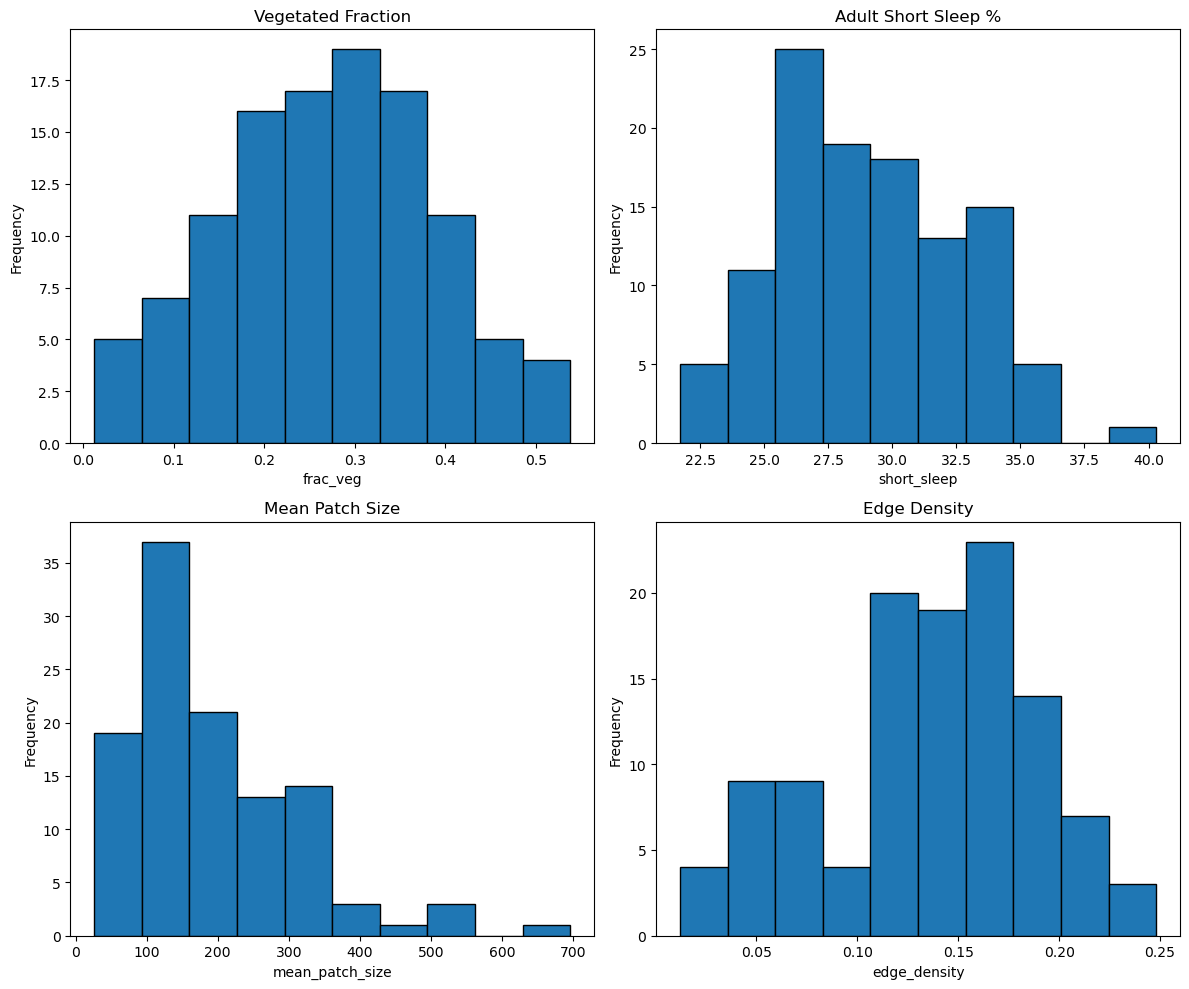

Wrote: histograms_sleep_vegetation.html


In [74]:
import matplotlib.pyplot as plt
import mpld3

# --- Histograms ---

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

variables = ["frac_veg", "short_sleep", "mean_patch_size", "edge_density"]
titles = ["Vegetated Fraction", "Adult Short Sleep %", "Mean Patch Size", "Edge Density"]

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i // 2, i % 2]
    ax.hist(
        chi_ndvi_cdc_gdf[var],
        bins=10,
        edgecolor="black",
    )
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")

# IMPORTANT: actually call tight_layout()
plt.tight_layout()

# Optional: save static image too
plt.savefig("histograms_sleep_vegetation.png", dpi=150, bbox_inches="tight")

# --- Save interactive HTML for GitHub Pages ---
mpld3.save_html(fig, "histograms_sleep_vegetation.html")

plt.show()

print("Wrote: histograms_sleep_vegetation.html")


In [57]:
## drop missing observations
model_df =(
    chi_ndvi_cdc_gdf

    ##make a copy
    .copy()

    ## subset to columns
    [['frac_veg', 'short_sleep', 'mean_patch_size', 'edge_density', 'geometry']]

    ## drop rows (observation) with missing value
    .dropna()
)

model_df

frac_veg  short_sleep  mean_patch_size  edge_density  \
0    0.315051         27.4       208.435907      0.144725   
1    0.012287         28.3        61.615385      0.012154   
2    0.055249         30.0        41.932967      0.059182   
3    0.298791         24.5       176.550651      0.198788   
4    0.297961         26.4       158.760393      0.216279   
..        ...          ...              ...           ...   
107  0.288895         26.9       178.755375      0.114123   
108  0.368477         28.3       216.132026      0.137982   
109  0.205275         29.1       148.418811      0.097962   
110  0.072104         32.2        91.953014      0.043531   
111  0.274495         29.1       169.491847      0.143654   

                                              geometry  
0    POLYGON ((-11691351.798 4834636.885, -11691351...  
1    POLYGON ((-11688301.532 4835632.272, -11688302...  
2    POLYGON ((-11688362.201 4834372.228, -11688360...  
3    POLYGON ((-11691355.36 4833538.467, -11691357....  
4    POLYGON ((-11692926.635 4832494.047, -11692925...  
..                                                 ...  
107  POLYGON ((-11679896.574 4824084.018, -11679896...  
108  POLYGON ((-11691351.798 4835608.508, -11691351...  
109  MULTIPOLYGON (((-11681197.008 4821951.258, -11...  
110  POLYGON ((-11688537.194 4817797.736, -11688985...  
111  POLYGON ((-11691342.668 4817773.296, -11691342...  

[112 rows x 5 columns]

In [59]:
### Perform variable transformation

### log of asthma rate
model_df['log_short_sleep'] = np.log(model_df.short_sleep)

## log of patch size
model_df['log_patch'] = np.log(model_df.mean_patch_size)

model_df

frac_veg  short_sleep  mean_patch_size  edge_density  \
0    0.315051         27.4       208.435907      0.144725   
1    0.012287         28.3        61.615385      0.012154   
2    0.055249         30.0        41.932967      0.059182   
3    0.298791         24.5       176.550651      0.198788   
4    0.297961         26.4       158.760393      0.216279   
..        ...          ...              ...           ...   
107  0.288895         26.9       178.755375      0.114123   
108  0.368477         28.3       216.132026      0.137982   
109  0.205275         29.1       148.418811      0.097962   
110  0.072104         32.2        91.953014      0.043531   
111  0.274495         29.1       169.491847      0.143654   

                                              geometry  log_short_sleep  \
0    POLYGON ((-11691351.798 4834636.885, -11691351...         3.310543   
1    POLYGON ((-11688301.532 4835632.272, -11688302...         3.342862   
2    POLYGON ((-11688362.201 4834372.228, -11688360...         3.401197   
3    POLYGON ((-11691355.36 4833538.467, -11691357....         3.198673   
4    POLYGON ((-11692926.635 4832494.047, -11692925...         3.273364   
..                                                 ...              ...   
107  POLYGON ((-11679896.574 4824084.018, -11679896...         3.292126   
108  POLYGON ((-11691351.798 4835608.508, -11691351...         3.342862   
109  MULTIPOLYGON (((-11681197.008 4821951.258, -11...         3.370738   
110  POLYGON ((-11688537.194 4817797.736, -11688985...         3.471966   
111  POLYGON ((-11691342.668 4817773.296, -11691342...         3.370738   

     log_patch  
0     5.339632  
1     4.120912  
2     3.736072  
3     5.173608  
4     5.067396  
..         ...  
107   5.186018  
108   5.375889  
109   5.000038  
110   4.521278  
111   5.132805  

[112 rows x 7 columns]

In [95]:
### Visualize transformed variables

hvplot.scatter_matrix(
    model_df[[
        'frac_veg',
        'edge_density',
        'log_patch',
        'log_short_sleep'
    ]]
)

:GridMatrix   [X,Y]
   :Histogram   [log_short_sleep]   (Count)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
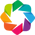

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/3259512982.py:2: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: scatter_matrix_transformed.html


In [75]:
hv.extension("bokeh")
pn.extension()

transformed_vars = ["frac_veg", "edge_density", "log_patch", "log_short_sleep"]

scatter_matrix_transformed = hvplot.scatter_matrix(
    model_df[transformed_vars]
).opts(
    width=250,
    height=250,
)

pn.pane.HoloViews(scatter_matrix_transformed).save(
    "scatter_matrix_transformed.html",
    resources="cdn",
    embed=False
)

print("Wrote: scatter_matrix_transformed.html")

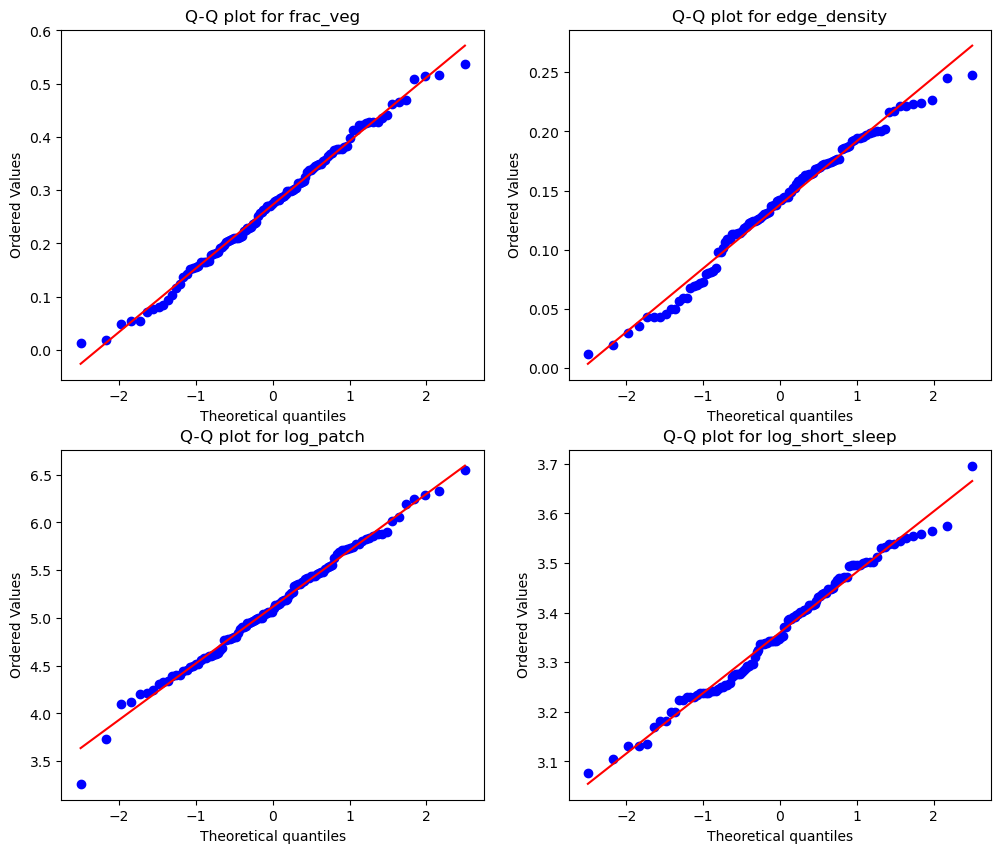

In [61]:
## make q-q plots


## set varaibles
var_qq = ['frac_veg', 'edge_density', 'log_patch', 'log_short_sleep']

## make q-q plot for each varaible
plt.figure(figsize = (12,10))
for i, var in enumerate(var_qq, 1):

    ## make 2X2 facets
    plt.subplot(2,2,i)

    ##normalize the distribution
    stats.probplot(model_df[var], dist = "norm", plot = plt)

    ## add title
    plt.title(f'Q-Q plot for {var}')

## plot it
plt.tight_layout
plt.show()

Reflect and respond: 
**EXPLAIN YOUR SELECTION AND TRANSFORMATION PROCESS HERE**

### Step 5b - Fit and Predict

If you have worked with statistical models before, you may notice that
the `scikitlearn` library has a slightly different approach than many
software packages. For example, `scikitlearn` emphasizes generic model
performance measures like cross-validation and importance over
coefficient p-values and correlation. The scikitlearn approach is meant
to generalize more smoothly to machine learning (ML) models where the
statistical significance is harder to derive mathematically.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the scikitlearn documentation or ChatGPT as a starting point,
split your data into training and testing datasets.</li>
<li>Fit a linear regression to your training data.</li>
<li>Use your fitted model to predict the testing values.</li>
<li>Plot the predicted values against the measured values. You can use
the following plotting code as a starting point.</li>
</ol></div></div>

In [84]:
### Select predictor and outcome variables

X = model_df[['edge_density', 'log_patch']]
y = model_df[['log_short_sleep']]

### Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size = 0.33, random_state = 19
)

### Fit a linear regression

reg = LinearRegression()

## fit to our data

reg.fit(X_train, y_train)

### Predict asthma values for the test dataset

y_test['pred_short_sleep'] = np.exp(reg.predict(X_test))

## real asthma rate for comparsion
y_test['short_sleep'] = np.exp(y_test.log_short_sleep)

y_test



log_short_sleep  pred_short_sleep  short_sleep
58          3.325036         28.485059         27.8
43          3.459466         31.162710         31.8
105         3.222868         24.543598         25.1
83          3.230804         30.678406         25.3
2           3.401197         35.732608         30.0
37          3.401197         27.745555         30.0
101         3.563883         30.316179         35.3
90          3.339322         26.194690         28.2
16          3.230804         30.489149         25.3
77          3.246491         26.273763         25.7
18          3.440418         30.442058         31.2
8           3.339322         31.537566         28.2
111         3.370738         28.803039         29.1
61          3.277145         27.109832         26.5
13          3.384390         31.331174         29.5
27          3.391147         29.421837         29.7
102         3.496508         30.927718         33.0
82          3.335770         27.727552         28.1
30          3.295837         29.278918         27.0
108         3.342862         27.858927         28.3
28          3.269569         28.584603         26.3
96          3.502550         32.325302         33.2
99          3.471966         32.788616         32.2
14          3.468856         30.091967         32.1
20          3.446808         29.142750         31.4
67          3.555348         32.960806         35.0
70          3.529297         31.893222         34.1
91          3.511545         26.726538         33.5
107         3.292126         28.760598         26.9
62          3.288402         27.212301         26.8
38          3.277145         26.484345         26.5
63          3.131137         25.520815         22.9
72          3.502550         29.922326         33.2
6           3.321432         28.736269         27.7
106         3.242592         38.529682         25.6
46          3.238678         24.499262         25.5
33          3.292126         26.218489         26.9

In [ ]:
### Plot measured vs. predicted asthma prevalence with a 1-to-1 line
y_max = y_test.short_sleep.max()
(
    y_test
    .hvplot.scatter(x='short_sleep', 
                    y='pred_short_sleep',
                    xlabel = "Measured Adult Short Sleep prevalance",
                    ylabel = "Predicted Adult Short Sleep prevalence",
                    title = "Linear regression: Predicted - Testing Data"
                    
                    )
    .opts(aspect='equal', 
          xlim=(0, y_max), ylim=(0, y_max), 
          width=600, height=600)
) * hv.Slope(slope=1, y_intercept=0).opts(color='black')

:Overlay
   .Scatter.I    :Scatter   [short_sleep]   (pred_short_sleep)
   .Annotation.I :Slope   [x,y]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
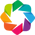

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/2422105793.py:2: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: measured_vs_predicted_short_sleep.html


In [76]:
hv.extension("bokeh")
pn.extension()

# --- Build measured vs predicted plot ---
y_max = y_test.short_sleep.max()

measured_vs_pred = (
    y_test.hvplot.scatter(
        x="short_sleep",
        y="pred_short_sleep",
        xlabel="Measured Adult Short Sleep Prevalence",
        ylabel="Predicted Adult Short Sleep Prevalence",
        title="Linear Regression: Predicted vs Testing Data",
    )
    .opts(
        aspect="equal",
        xlim=(0, y_max),
        ylim=(0, y_max),
        width=600,
        height=600,
    )
) * hv.Slope(slope=1, y_intercept=0)

# --- Save to HTML ---
pn.pane.HoloViews(measured_vs_pred).save(
    "measured_vs_predicted_short_sleep.html",
    resources="cdn",
    embed=False,
)

print("Wrote: measured_vs_predicted_short_sleep.html")

### Step 5c - Explore spatial bias

We always need to think about bias, or systematic error, in model
results. Every model is going to have some error, but we’d like to see
that error evenly distributed. When the error is systematic, it can be
an indication that we are missing something important in the model.

In geographic data, it is common for location to be a factor that
doesn’t get incorporated into models. After all – we generally expect
places that are right next to each other to be more similar than places
that are far away (this phenomenon is known as *spatial
autocorrelation*). However, models like this linear regression don’t
take location into account at all.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Compute the model error (predicted - measured) for all census
tracts</li>
<li>Plot the error as a chloropleth map with a diverging color
scheme</li>
<li>Looking at both of your error plots, what do you notice? What are
some possible explanations for any bias you see in your model?</li>
</ol></div></div>

In [81]:
### Compute model error for all census tracts

## use the trained model to predict the asthma prevalence for each census tract

model_df['pred_short_sleep'] = np.exp(reg.predict(X))

## calculate model error

model_df['error_short_sleep'] = model_df['pred_short_sleep'] - model_df['short_sleep']

### Plot error geographically as a chloropleth
(
    gv.tile_sources.EsriImagery*plot_chloropleth(model_df, color='error_short_sleep', cmap='RdBu')
    ## set frame width, aspect ratio, and title
    .opts(
        frame_width=600,
        aspect='equal',
        title="Short Sleep Model Error by Census Tract (Predicted − Observed)"
    )
)



:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (frac_veg,short_sleep,mean_patch_size,edge_density,log_short_sleep,log_patch,pred_short_sleep,error_short_sleep)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
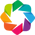

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_96454/4170318833.py:2: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Wrote: short_sleep_model_error_map.html


In [100]:
hv.extension("bokeh")
pn.extension()

model_df["pred_short_sleep"] = np.exp(reg.predict(X))
model_df["error_short_sleep"] = model_df["pred_short_sleep"] - model_df["short_sleep"]

error_map = (
    gv.tile_sources.EsriImagery
    * plot_chloropleth(
        model_df,
        color="error_short_sleep",
        cmap="RdBu",
        title="Short Sleep Model Error by Census Tract (Predicted − Observed)",
    ).opts(
        text_font_size="11pt"   # 👈 this is the one your install supports
    )
).opts(
    frame_width=600,
    aspect="equal",
)

pn.pane.HoloViews(error_map).save(
    "short_sleep_model_error_map.html",
    resources="cdn",
    embed=False,
)

print("Wrote: short_sleep_model_error_map.html")


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about your model from looking at the error plots?
What additional data, transformations, or model type might help improve
your results?</p></div></div>

Based on what I'm seening, vegetation ends up being a pretty weak predictor of asthma. The model mostly predicts values near the mean and doesn’t capture the full range of observed asthma prevalence. The spatial error map also shows strong regional patterns, essentially overpredicting asthma in the Northern parts or the city and under predicting it in the Sourthern regions. To me, this suggests that much more important drivers—like air quality, socioeconomic factors, and access to healthcare—aren’t being represented. In other words, NDVI alone isn’t enough to explain asthma variability across census tracts.